# Reduce PDS data

To _reduce_ PDS may be different across different datasets/product-types

Here, we are going to work with MEX/HRSC data.

In [1]:
dataset = 'hrsc'

In [2]:
from gpt.helpers import collection

from importlib import reload
reload(collection)

<module 'gpt.helpers.collection' from '/mnt/data/repos/GMAP/gpt/gpt/helpers/collection.py'>

In [3]:
ls ../01_search-download_from_ode-pds/

01_search_data_products.ipynb    download_ctx.geojson     search_ctx.geojson
02_download_data_products.ipynb  download_hirise.geojson  search_hirise.geojson
data@                            download_hrsc.geojson    search_hrsc.geojson


In [4]:
from pathlib import Path

db_path = Path(f'../01_search-download_from_ode-pds/download_{dataset}.geojson')

archive = collection.from_geojson(db_path.as_posix())

In [5]:
archive

                                            geometry BB_georeferenced  \
0  MULTIPOLYGON (((-0.21680 3.84280, -0.21600 3.9...             True   
1  MULTIPOLYGON (((-0.21680 3.84280, -0.21600 3.9...             True   
2  POLYGON ((-1.73400 -11.89400, -1.73800 -11.644...             True   
3  POLYGON ((-1.73400 -11.89400, -1.73800 -11.644...             True   

  Center_georeferenced Center_latitude Center_longitude  \
0                 True         -1.7901           0.2893   
1                 True         -1.7901           0.2893   
2                 True         -4.8102         358.8204   
3                 True         -4.8102         358.8204   

                            Data_Set_Id Easternmost_longitude  \
0  MEX-M-HRSC-5-REFDR-MAPPROJECTED-V3.0               359.784   
1  MEX-M-HRSC-5-REFDR-MAPPROJECTED-V3.0               359.784   
2  MEX-M-HRSC-5-REFDR-MAPPROJECTED-V3.0               359.921   
3  MEX-M-HRSC-5-REFDR-MAPPROJECTED-V3.0               359.921   

            

## Data and metadata processing

We have in our data store those four product files:
```
0  ./data/MEX/HRSC/REFDR3/h1998_0000_nd3.jp2  
1  ./data/MEX/HRSC/REFDR3/h1998_0000_nd3.lbl  
2  ./data/MEX/HRSC/REFDR3/ha482_0000_nd3.jp2  
3  ./data/MEX/HRSC/REFDR3/ha482_0000_nd3.lbl  
```
corresponding to image/data and header/metadata files for two data products: `h1998_0000_nd3` and `ha482_0000_nd3`.

Images are in [JPEG2000]() format, while the headers are in [PDS LABEL]() format.

We want to convert those JP2 images into geotiff and just check what PDS LABEL files look like.

### JP2 to GeoTIFF with `gdal_translate`

In the [GDAL toolkit](https://gdal.org/programs/raster_common_options.html), `gdal_translate` can be used to do this format transformation.

The simplest for of the command is:
```bash
$ gdal_translate input.jp2 result.tif
```
, `gdal_translate` should be able to understand the file formats we are refeering to (JP2, GeoTIFF, respectively) and do the conversion automatically.

We can, though, add [some options](https://gdal.org/programs/gdal_translate.html) to optimize (size, performance) the generated GeoTIFF raster.
For isntance, we could add options `COMPRESS=JPEG` and `TILED=YES` for a smaller image and tiled for optimized partial reading [COG]():
```bash
$ gdal_translate -of GTiff -co COMPRESS=JPEG -co TILED=YES input.jp2 result.tif
```

For educational reasons, I will run `gdal_translate` from here, inside the Python environment, with the help of the [sh](https://amoffat.github.io/sh/index.html), a binder for command line commands to Python.

In [6]:
from sh import gdal_translate

gdal_translate = gdal_translate.bake(of='GTiff', co='COMPRESS=JPEG', _long_prefix="-", _long_sep=" ")

In [7]:
gdal_translate('./data/MEX/HRSC/REFDR3/h1998_0000_nd3.jp2', 'h1998_0000_nd3.tif')

Input file size is 6105, 56456
0...10...20...30...40...50...60...70...80...90...100 - done.

In [8]:
gdal_translate('./data/MEX/HRSC/REFDR3/ha482_0000_nd3.jp2', 'ha482_0000_nd3.tif')

Input file size is 10150, 67328
0...10...20...30...40...50...60...70...80...90...100 - done.

In [9]:
%matplotlib inline

from matplotlib import pyplot as plt

import rasterio
from rasterio.plot import show

<AxesSubplot:title={'center':'ha482_0000_nd3'}>

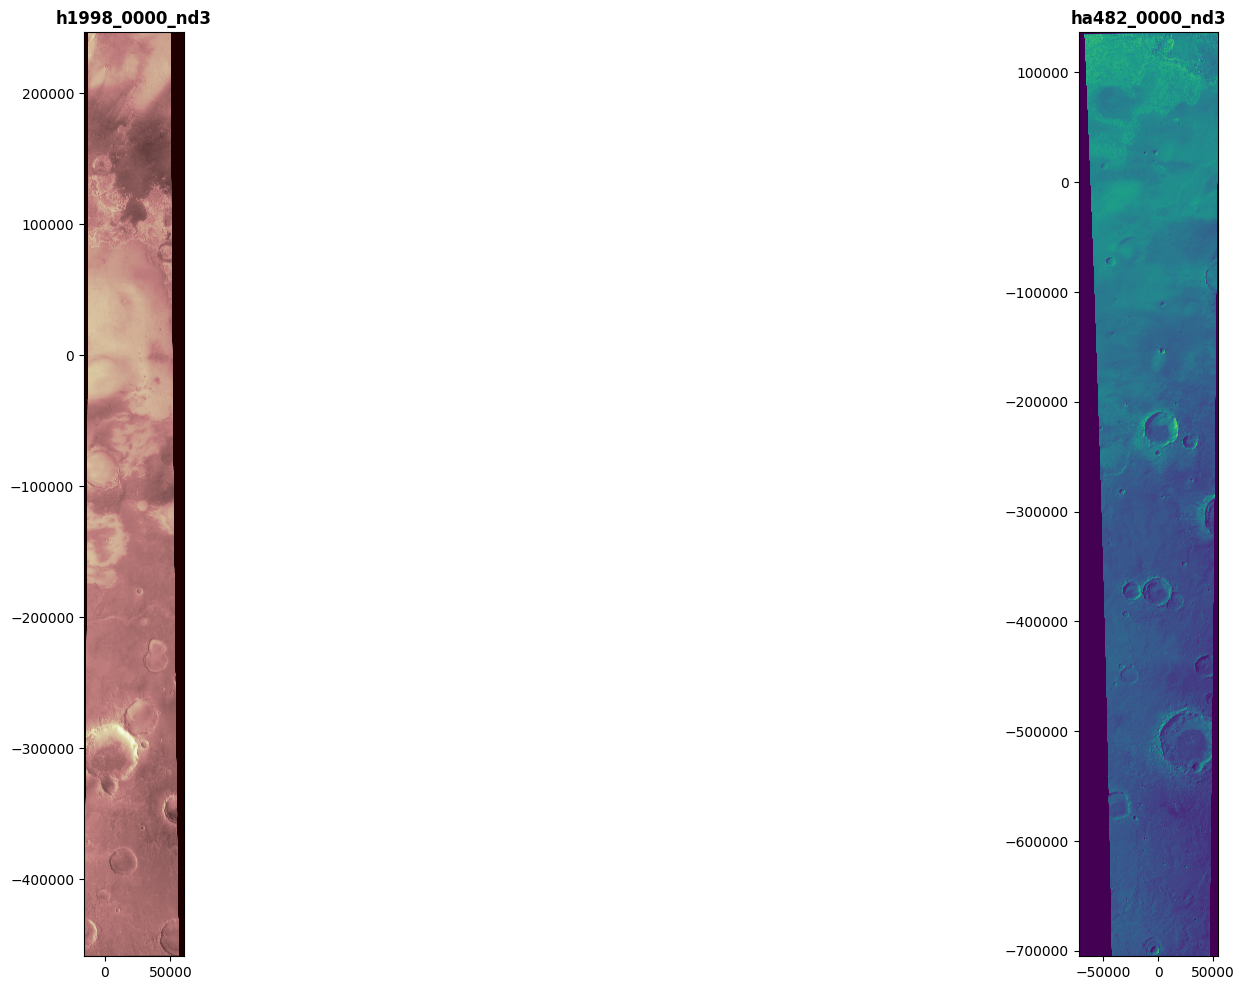

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,12))

h1998_0000_nd3 = rasterio.open('h1998_0000_nd3.tif')
ha482_0000_nd3 = rasterio.open('ha482_0000_nd3.tif')

show((h1998_0000_nd3, 1), ax=ax1, cmap='pink', title='h1998_0000_nd3')
show((ha482_0000_nd3, 1), ax=ax2, cmap='viridis', title='ha482_0000_nd3')

In [12]:
%cat ./data/MEX/HRSC/REFDR3/h1998_0000_nd3.lbl 

PDS_VERSION_ID                    = PDS3

/* FILE DATA ELEMENTS */

RECORD_TYPE                       = STREAM

/* POINTERS TO DATA OBJECTS */

^COMPRESSED_FILE                  = "H1998_0000_ND3.JP2"

/* IDENTIFICATION DATA ELEMENTS */

DATA_SET_ID                       = "MEX-M-HRSC-5-REFDR-MAPPROJECTED-V3.0"
DATA_SET_NAME                     = "MARS EXPRESS HRSC MAP PROJECTED REFDR 
                                     V3.0"
DETECTOR_ID                       = MEX_HRSC_NADIR
EVENT_TYPE                        = "MARS-LOCAL-CARTOGRAPHY-Lc-La-Tc"
INSTRUMENT_HOST_ID                = MEX
INSTRUMENT_HOST_NAME              = "MARS EXPRESS"
INSTRUMENT_ID                     = HRSC
INSTRUMENT_NAME                   = "HIGH RESOLUTION STEREO CAMERA"
MISSION_NAME                      = "MARS EXPRESS"
MISSION_PHASE_NAME                = MR_Phase_7
PROCESSING_LEVEL_ID               = 3
PRODUCT_CREATION_TIME             = 2016-03-09T16:25:58.000Z
PRODUCT_ID                        = "H1998_0000_ND

In [13]:
%cat ./data/MEX/HRSC/REFDR3/ha482_0000_nd3.lbl  

PDS_VERSION_ID                    = PDS3

/* FILE DATA ELEMENTS */

RECORD_TYPE                       = STREAM

/* POINTERS TO DATA OBJECTS */

^COMPRESSED_FILE                  = "HA482_0000_ND3.JP2"

/* IDENTIFICATION DATA ELEMENTS */

DATA_SET_ID                       = "MEX-M-HRSC-5-REFDR-MAPPROJECTED-V3.0"
DATA_SET_NAME                     = "MARS EXPRESS HRSC MAP PROJECTED REFDR 
                                     V3.0"
DETECTOR_ID                       = MEX_HRSC_NADIR
EVENT_TYPE                        = "MARS-REGIONAL-MAPPING-Im-Fl-La"
INSTRUMENT_HOST_ID                = MEX
INSTRUMENT_HOST_NAME              = "MARS EXPRESS"
INSTRUMENT_ID                     = HRSC
INSTRUMENT_NAME                   = "HIGH RESOLUTION STEREO CAMERA"
MISSION_NAME                      = "MARS EXPRESS"
MISSION_PHASE_NAME                = ME_Phase_25
PROCESSING_LEVEL_ID               = 3
PRODUCT_CREATION_TIME             = 2016-10-27T12:16:28.000Z
PRODUCT_ID                        = "HA482_0000_ND